# LAB 6 MOS:  Algoritmos Genéticos para Resolución de Problemas Complejos

- Samuel Augusto Hernandez 202213772
- Tomas Alberto Rodriguez 2022128686

## Problema 1: Corridor Crawler (Laberinto Determinístico)

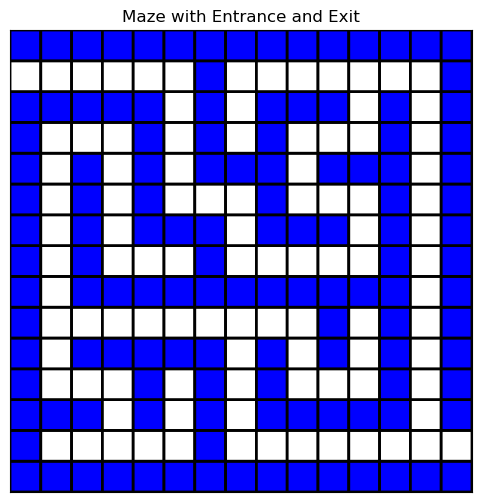

In [20]:
import random
from deap import base, creator, tools, algorithms
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# Create a function to load the maze from a text file
def load_maze(file):
    maze = np.loadtxt(file, dtype=int)
    return maze

def display_maze(maze):
    cmap = ListedColormap(['white', 'black', 'green', 'blue'])
    plt.figure(figsize=(6, 6))
    plt.pcolor(maze[::-1], cmap=cmap, edgecolors='k', linewidths=2)
    plt.gca().set_aspect('equal')
    plt.xticks([])
    plt.yticks([])
    plt.title('Maze with Entrance and Exit')
    plt.show()


#maze = load_maze('maze_case_base.txt')
maze = load_maze('maze_case_base.txt')
n = maze.shape[0]
#maze[n-2, n-1] = 3  # salida
#maze[9, 10] = 3  # salida
#maze[1, 0] = 3  # entrada
#maze[1, 1] = 2 # medio
#maze[3, 1] = 2 # medio
display_maze(maze)

### Representación Cromosómica

El tamaño del cromosoma será de n², donde n es el tamaño del laberinto. Este tamaño asegura que nunca se necesitarán más de n² pasos para llegar a la salida, ya que el robot siempre encontrará la salida en un número menor de pasos, y las dimensiones del laberinto dictarán el límite máximo de movimientos

Cada gen representará un movimiento. Los posibles movimientos seran 4 direcciones: norte, sur, este, oeste. Cada gen será representado por un número que indica la acción a tomar.

Si en algun punto llega a la salida antes de su ultimo movimiento, se considera que es correcto y no se toma en cuenta lo que quede de cromosoma



### Operadores Geneticos

### Implementación de Operadores Geneticos

In [21]:
from numpy import sqrt
# Parámetros (todos dependen de n, así evitamos valores “rígidos”)
GOAL_FACTOR       = 10        # Meta: 10·n²  (ajústalo si quieres más/menos peso)
COLLISION_FACTOR  = 1         # Choque: –1·n
OUT_FACTOR        = 2         # Fuera: –2·n  (peor que chocar)
STEP_COST         = 0.5       # Penaliza pasos extra (–steps/2)

def _exploration_reward(visited, n):
    """
    Recompensa proporcional al % de casillas únicas visitadas.
    Máximo ≈ n  (si se recorren todas las celdas).
    """
    return len(visited)* n

def _closeness_reward(dist, n):
    """
    Recompensa cuadrática por cercanía a la meta.
    Escala 0…n² (máximo cuando dist = 0).  (1-dist_norm)² amplifica
    la ganancia a medida que el robot se aproxima.
    """
    max_dist = sqrt((n-1)**2 + (n-2)**2)
    return ((1 - dist / max_dist) ** 2) * n * n



def evaluate2(individual, maze):
    """
    Función de aptitud para GA (devuelve (fitness,) como espera DEAP).

    1 = pared, 0 = celda libre
    Inicio fijo: (x=0, y=1)
    Meta fija:   (x=n-1, y=n-2)
    """
    n          = maze.shape[0]
    goal       = (n-1, n-2)
    x, y       = 0, 1                # posición inicial
    steps      = 0
    visited    = {(x, y)}            # conjunto de celdas distintas visitadas

    for move in individual:
        steps += 1
        if   move == '1':  y -= 1    # Norte
        elif move == '2':  y += 1    # Sur
        elif move == '3':  x += 1    # Este
        elif move == '4':  x -= 1    # Oeste

        # ---------- 1) fuera de límites ----------
        if x < 0 or y <= 0 or x >= n or y >= n:
            dist   = sqrt((goal[0] - x)**2 + (goal[1] - y)**2)
            fitness = (
                -OUT_FACTOR * n
                + _exploration_reward(visited, n)
                + _closeness_reward(dist, n)
                - STEP_COST * steps
            )
            return fitness,

        # ---------- 2) colisión con pared ----------
        if maze[y, x] == 1:
            dist   = sqrt((goal[0] - x)**2 + (goal[1] - y)**2)
            fitness = (
                -COLLISION_FACTOR * n
                + _exploration_reward(visited, n)
                + _closeness_reward(dist, n)
                - STEP_COST * steps
            )
            return fitness,

        visited.add((x, y))

        # ---------- 3) llegó a la meta ----------
        if (x, y) == goal:
            fitness = GOAL_FACTOR * n * n - steps   # recompensa gigante – pasos
            return fitness,

    # ---------- 4) se acabaron los movimientos y no llegó ----------
    dist = sqrt((goal[0] - x)**2 + (goal[1] - y)**2)
    fitness = (
        _exploration_reward(visited, n)
        + _closeness_reward(dist, n)
        - STEP_COST * steps
    )
    return fitness,

In [22]:
# Definir las posibles acciones



MOVES = ['1', '2', '3', '4']  # Norte, Sur, Este, Oeste

n = maze.shape[0]  # Tamaño del laberinto

def create_individual(n):
    #return [random.choice(MOVES) for _ in range((n-2)**2)]
    return [random.choice(MOVES) for _ in range((n-2)*n//2)]

# Crear los elementos de DEAP
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximizar aptitud
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()


# Función que envolviera la creación del individuo y le pasara el tamaño 'n'
def create_individual_with_size():
    return create_individual(n)

toolbox.register("individual", tools.initIterate, creator.Individual, create_individual_with_size)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


def penalizacion(n, x, y):
    # Distancia entre el final y el punto x,y
    #dist = (abs(n-1 - x) + abs(n-2 - y)) # Distancia de Manhattan
    dist = sqrt((n-1-x)**2 + (n-2-y)**2)  # Distancia euclidiana
    return dist**2  # Penalización por distancia al objetivo

# Función de aptitud ajustada
def evaluate(individual, maze):
    n = maze.shape[0]  # Tamaño del laberinto
    x, y = 0, 1  # Posición inicial del robot
    steps = 0
    for move in individual:
        steps += 1
        if move == '1':
            y -= 1
        elif move == '2':
            y += 1
        elif move == '3':
            x += 1
        elif move == '4':
            x -= 1

        # Comprobar si el robot choca con una pared (en el laberinto)
        if maze[y][x] == 1:
            return -(n*n) + steps - penalizacion(n,x,y),  # Penalización por colisión
            # Es mejor que el robot choque con una pared luego de haber recorrido una distancia considerable, 
            # por lo que se penaliza menos que si choca luego de varios pasos

        # Comprobar si el robot está fuera de los límites del laberinto
        if x < 0 or y < 0 or x >= n or y >= n:
            return -(n*n) + steps - penalizacion(maze,x,y),  # Penalización por salirse del laberinto

        # Si llegó a la salida (suponiendo que la salida está en la última posición (n-1, n-1))
        if (x, y) == (n-1, n-2):
            # Si llegó a la salida, devuelve positivo
            return n*n - steps,  # Se penaliza por el número de pasos

    # Si no llega a la salida, penaliza la distancia recorrida
    return -steps//2,  # Penaliza por la cantidad de pasos

def mutFlipMove(individual, indpb):
    MOVES = ['1', '2', '3', '4']   # 1=Norte, 2=Sur, 3=Este, 4=Oeste

    for i in range(len(individual)):
        if random.random() < indpb:
            individual[i] = random.choice(MOVES)

    return individual,

toolbox.register("evaluate", evaluate2, maze = maze)

# Operadores genéticos
toolbox.register("mate", tools.cxOnePoint)  # Cruce de dos puntos
toolbox.register("mutate", mutFlipMove, indpb=0.1)  # Mutación
toolbox.register("select", tools.selTournament, tournsize=3)  # Selección por torneo

pop = toolbox.population(n=200)  # Crear población con 100 individuos

# Parámetros del algoritmo genético
prob_mate = 0.7  # Probabilidad de cruce
prob_mutate = 0.1  # Probabilidad de mutación
generation = 300  # Número de generaciones

# Estadísticas
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

# Hall of Fame
hof = tools.HallOfFame(2)

# Ejecución del algoritmo genético
random.seed(40)
pop, log = algorithms.eaSimple(pop, toolbox,
                               cxpb=prob_mate, mutpb=prob_mutate,
                               ngen=generation, stats=stats,
                               halloffame=hof, verbose=True)


gen	nevals	avg     	min  	max    
0  	200   	-4.34849	-15.5	50.7626
1  	144   	7.13128 	-15.5	50.7626
2  	157   	21.3503 	-0.680264	50.7626
3  	154   	34.1262 	-15.4933 	50.7626
4  	130   	43.1767 	16.6557  	50.7626
5  	164   	46.9628 	-15.4933 	50.7626
6  	159   	50.258  	-15.4933 	50.7626
7  	134   	49.7159 	-15.4933 	50.7626
8  	143   	49.4599 	-0.680264	63.6869
9  	150   	49.5179 	-15.5    	50.7626
10 	150   	50.7626 	50.7626  	50.7626
11 	145   	49.5292 	-15.4933 	50.7626
12 	134   	49.6068 	-15.4933 	50.7626
13 	154   	49.4987 	-15.5    	50.7626
14 	150   	50.1506 	-15.5    	50.7626
15 	151   	49.8619 	-0.680264	50.7626
16 	146   	50.1152 	-15.4933 	50.7626
17 	142   	50.0254 	-15.4933 	50.7626
18 	163   	49.5571 	-15.5    	50.7626
19 	147   	50.199  	-0.680264	50.7626
20 	145   	49.8604 	0.542549 	50.7626
21 	145   	49.9533 	-0.680264	50.7626
22 	146   	49.9199 	-15.5    	50.7626
23 	142   	50.0542 	-0.680264	50.7626
24 	150   	50.0588 	-0.680264	50.7626
25 	144   	49.8231 	0.54

### Visualización de Trayectoria


Mejor individuo (cromosoma): ['3', '3', '3', '3', '3', '2', '2', '2', '2', '3', '3', '2', '2', '3', '4', '3', '3', '3', '3', '1', '1', '4', '3', '2', '2', '2', '3', '4', '4', '3', '4', '3', '4', '3', '2', '3', '2', '2', '1', '4', '2', '1', '1', '2', '4', '4', '1', '2', '1', '1', '4', '2', '1', '3', '1', '2', '3', '2', '1', '2', '2', '2', '3', '1', '4', '4', '3', '1', '1', '4', '3', '3', '2', '3', '1', '2', '4', '3', '3', '2', '3', '4', '4', '1', '2', '3', '1', '1', '3', '2', '3', '4', '3', '2', '3', '4', '2']
97
Fitness: 395.6162170140245
Chocó con una pared


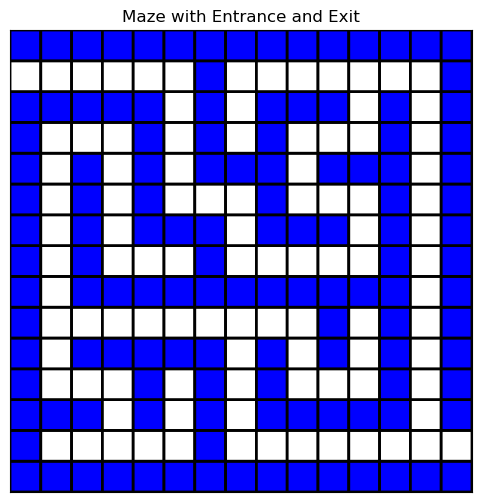

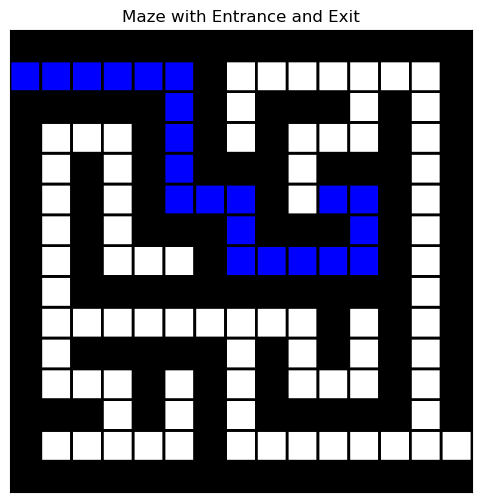

In [23]:
# Mostrar resultados finales
best = hof[0]
print("\nMejor individuo (cromosoma):", best)
print(len(best))
fitness_val = best.fitness.values[0]
print("Fitness:", fitness_val)

#if fitness_val > 0:
    #print("El robot llegó a la salida.")
    # Visualización del camino recorrido por el mejor individuo
path = []
steps = 0
x, y = 0, 1
path.append((x, y))
maze_camino = maze.copy()
maze_camino[1][0] = 3
for move in best:
    steps += 1
    if move == '1': # Moverse hacia arriba
            y -= 1
    elif move == '2': # Moverse hacia abajo
            y += 1
    elif move == '3': # Moverse hacia la derecha
            x += 1
    elif move == '4': # Moverse hacia la izquierda
            x -= 1
    path.append((x, y))
    if maze[y][x] == 1:
        print("Chocó con una pared")
        break
    if not(x < 1 or y < 1 or x >= n or y >= n-1):
        maze_camino[y][x] = 3
    else:
        print("Fuera de los límites del laberinto")
        break
    if (x, y) == (n-1, n-2):
        break  # Salir si llegó a la salida

display_maze(maze)  # Mostrar el laberinto con el camino recorrido
display_maze(maze_camino)  # Mostrar el laberinto con el camino recorrido
#else:
    #print("El robot no llegó a la salida.")


### Analisis de convergencia